In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

# Read data
file_path = 'data/btc_krw_sorted.csv'
df = pd.read_csv(file_path)

# Rename columns to match the specified format
df.columns = ['timestamp', 'Exchange Rate','close','open', 'high', 'low', 'volume', 'change']

# Drop the first row (which will have NaN change due to pct_change())
df = df.dropna()

# Select the 'close' price for prediction
data = df['close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:]

# Create dataset for LSTM input
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 5  # Use the past 5 days' data to predict the next day's value
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape data for LSTM input: [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")




Training data shape: (2184, 5, 1), Training labels shape: (2184,)
Testing data shape: (542, 5, 1), Testing labels shape: (542,)


In [8]:
# Build the CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))  # Add 1D Convolutional Layer
model.add(MaxPooling1D(pool_size=2))  # Add MaxPooling Layer

# Add LSTM Layer
model.add(LSTM(units=50, activation='tanh'))

model.add(Flatten())  # Flatten the input for the Dense layer
model.add(Dense(50, activation='relu'))  # Add Dense Layer with ReLU activation
model.add(Dense(1))  # Output Layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)

# Train the model and save training history with early stopping
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_split=0.2, callbacks=[early_stop])


2024-12-05 13:03:53.806352: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-05 13:03:53.850873: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-05 13:03:53.850923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-05 13:03:53.853378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-05 13:03:53.853417: I external/local_xla/xla/stream_executor

Epoch 1/100


2024-12-05 13:04:05.387220: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905
2024-12-05 13:04:06.101691: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f181d0dae50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-05 13:04:06.101718: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-12-05 13:04:06.105184: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733371446.160456   58266 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 [==============================] - 3s 8ms/step - loss: 0.0038 - val_loss: 1.1359e-04
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 1.9184e-04 - val_loss: 1.1931e-04
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 1.8416e-04 - val_loss: 1.3215e-04
Epoch 4/100
110/110 [==============================] - 0s 5ms/step - loss: 1.7294e-04 - val_loss: 2.4386e-04
Epoch 5/100
110/110 [==============================] - 0s 5ms/step - loss: 2.0624e-04 - val_loss: 1.4667e-04
Epoch 6/100
110/110 [==============================] - 0s 5ms/step - loss: 1.9287e-04 - val_loss: 1.1593e-04
Epoch 7/100
110/110 [==============================] - 0s 4ms/step - loss: 1.5830e-04 - val_loss: 1.5634e-04
Epoch 7: early stopping


In [9]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

17/17 [==============================] - 0s 5ms/step


In [10]:
# In the scaling of predictions to original values
train_predict_scaled = scaler.inverse_transform(train_predict)
test_predict_scaled = scaler.inverse_transform(test_predict)
y_train_scaled = scaler.inverse_transform([y_train])
y_test_scaled = scaler.inverse_transform([y_test])


In [11]:
# Adjust the shape of y_train and y_test
y_train_scaled = y_train_scaled.reshape(-1, 1)
y_test_scaled = y_test_scaled.reshape(-1, 1)


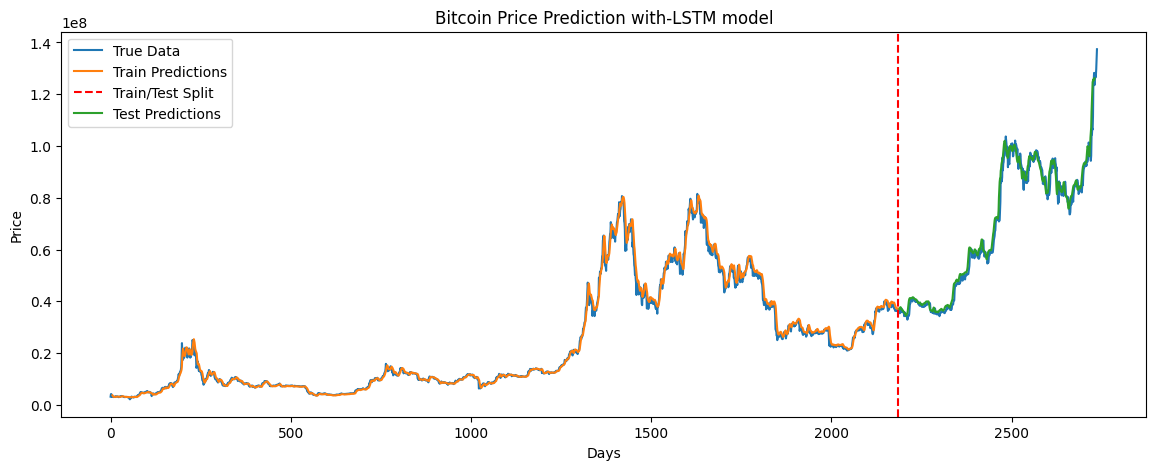

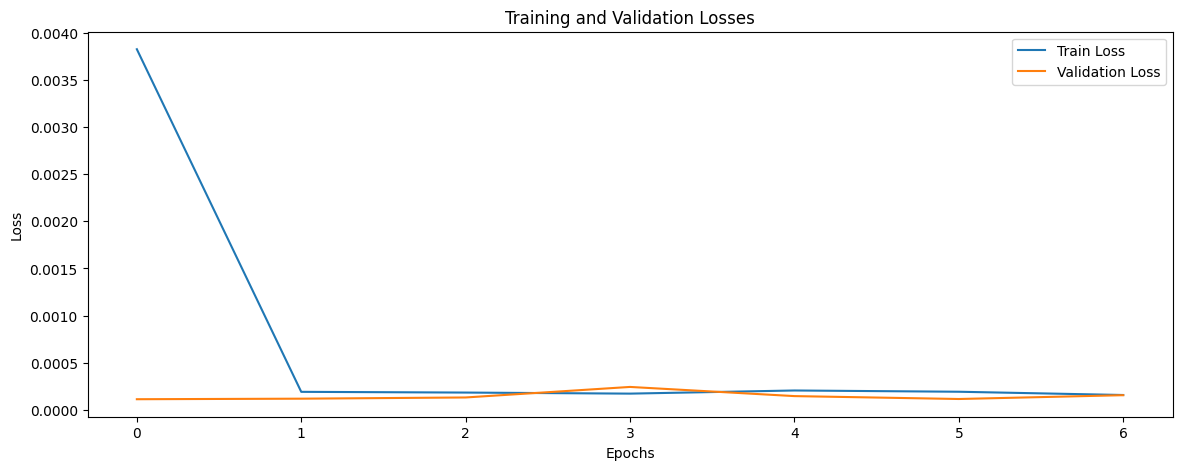

In [12]:


# Plotting the training data predictions
plt.figure(figsize=(14, 5))
plt.plot(data, label='True Data')
plt.plot(range(look_back, len(train_predict_scaled) + look_back), train_predict_scaled, label='Train Predictions')
plt.axvline(x=len(train_predict_scaled), color='r', linestyle='--', label='Train/Test Split')
plt.plot(range(len(train_predict_scaled) + look_back, len(train_predict_scaled) + look_back + len(test_predict_scaled)), test_predict_scaled, label='Test Predictions')
plt.title('Bitcoin Price Prediction with-LSTM model')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting the losses during training
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Evaluate the model on the training data
train_loss = model.evaluate(X_train, y_train, verbose=1)
print(f"Training Loss: {train_loss}")

# Evaluate the model on the testing data
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Testing Loss: {test_loss}")

69/69 [==============================] - 0s 2ms/step - loss: 1.6115e-04
Training Loss: 0.00016114916070364416
17/17 [==============================] - 0s 2ms/step - loss: 3.6833e-04
Testing Loss: 0.00036833129706792533
